# Notebook for task 2 and 3
*TDT 4300 - Exercise 3 - Frederick Nilsen*

In [140]:
# Imports
import numpy as np
import pandas as pd
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

### 2 HAC with min and max-link

We import and show the distance matrix

In [141]:
data = np.array([[5,7],[4,3],[9,8],[5,6],[11,3]])
prox_matrix = pdist(data)
names = ['A','B','C','D','E']
pd.DataFrame(squareform(prox_matrix), columns=names, index=names)

,A,B,C,D,E
A,0.000000,4.123106,4.123106,1.000000,7.211103
B,4.123106,0.000000,7.071068,3.162278,7.000000
C,4.123106,7.071068,0.000000,4.472136,5.385165
D,1.000000,3.162278,4.472136,0.000000,6.708204
E,7.211103,7.000000,5.385165,6.708204,0.000000


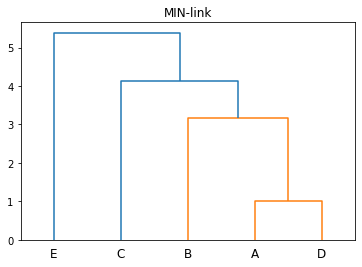

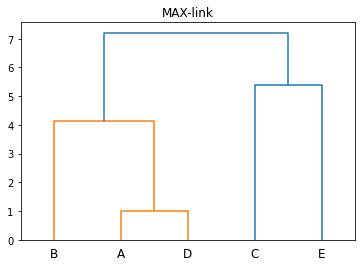

In [142]:
Z_min = hierarchy.linkage(prox_matrix, 'single')
Z_max = hierarchy.linkage(prox_matrix, method='complete')

#Plotting
titles = ["MIN-link", "MAX-link"]
Zs = [Z_min, Z_max]
for title, Z in zip(titles, Zs):
    plt.title(title)
    dn = hierarchy.dendrogram(Z, labels=names)
    plt.show()

### 3 DBSCAN

We start by importing the points and finding the proximity matrix using `pdist`.

In [143]:
data = pd.read_csv("points_dbscan.csv", header=0, index_col='id')
prox_matrix = pdist(data)
pd.DataFrame(squareform(prox_matrix))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,14.764823,15.556349,9.000000,10.049876,5.385165,14.866069,14.764823,6.324555,9.000000,11.000000,8.246211,10.770330,6.708204,12.165525
1,14.764823,0.000000,4.472136,8.062258,12.369317,11.180340,5.000000,0.000000,8.602325,8.062258,13.601471,11.045361,4.242641,8.062258,5.099020
2,15.556349,4.472136,0.000000,11.180340,10.049876,10.816654,1.000000,4.472136,10.295630,11.180340,11.000000,9.486833,7.071068,9.433981,9.055385
3,9.000000,8.062258,11.180340,0.000000,12.806248,8.602325,11.045361,8.062258,3.605551,0.000000,14.212670,10.630146,4.123106,4.242641,3.605551
4,10.049876,12.369317,10.049876,12.806248,0.000000,5.099020,9.055385,12.369317,9.433981,12.806248,1.414214,2.236068,10.816654,8.602325,13.601471
5,5.385165,11.180340,10.816654,8.602325,5.099020,0.000000,10.000000,11.180340,5.000000,8.602325,6.324555,3.000000,8.062258,4.472136,10.440307
6,14.866069,5.000000,1.000000,11.045361,9.055385,10.000000,0.000000,5.000000,9.848858,11.045361,10.000000,8.544004,7.000000,8.944272,9.219544
7,14.764823,0.000000,4.472136,8.062258,12.369317,11.180340,5.000000,0.000000,8.602325,8.062258,13.601471,11.045361,4.242641,8.062258,5.099020
8,6.324555,8.602325,10.295630,3.605551,9.433981,5.000000,9.848858,8.602325,0.000000,3.605551,10.816654,7.211103,4.472136,1.000000,6.000000
9,9.000000,8.062258,11.180340,0.000000,12.806248,8.602325,11.045361,8.062258,3.605551,0.000000,14.212670,10.630146,4.123106,4.242641,3.605551


We now define functions to find the core points and the border points. The remaining points must then be noise points.

The cores are found by iterating through each column of the proximity matrix, and finding the number of rows whose values are $\le \varepsilon$. If this number is greater or equal to *MinPts*, we append the index to the column (point) to a core-list.

When finding border points, we iterate through the known core points and find all points that are at most $\varepsilon$ away from the cores. For each neighbor, if it is not already a core, it is assigned as a border point.

We use $\texttt{MinPts} = 3$ and $\varepsilon=4$ as given.

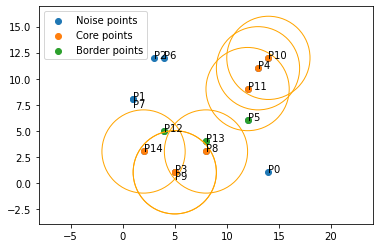

In [145]:
def core_indices(prox_matrix, Eps=4, MinPts=3):
    """Finds indices of points that are cores"""
    cores = []
    N = prox_matrix.shape[0]
    for i in range(N):
        number_of_neighbors = np.count_nonzero(prox_matrix[i,:] <= Eps)
        if number_of_neighbors >= MinPts:
            cores.append(i)
    return cores
def border_indices(prox_matrix, core_ind, Eps=4):
    """Finds border indices based on proximity matrix and already-found cores"""
    borders = []
    for c in core_ind:
        candidates = np.where(prox_matrix[c,:] <= Eps)
        for candidate in candidates[0]:
            if candidate not in core_ind:
                borders.append(candidate)
    return borders


distances_full = squareform(pdist(data))
cores = core_indices(distances_full)
borders = border_indices(distances_full, cores)

fig, ax = plt.subplots()
ax.scatter(data.x, data.y, label="Noise points")
ax.scatter(data.x[cores], data.y[cores], label="Core points")
ax.scatter(data.x[borders], data.y[borders], label="Border points")

# Annotate
points_to_pad = [7,9]
for i in range(len(data)):
    pad = 0.7 if i in points_to_pad else 0
    ax.annotate("P"+str(i), (data.x[i], data.y[i] - pad ))

# Plot circles from cores 
ax.set_aspect('equal', adjustable='datalim')
for c in cores:
    cir = plt.Circle((data.x[c], data.y[c]), 4, color='orange', fill=False)
    ax.add_patch(cir)

plt.legend()
plt.show()
